In [9]:
import os
import glob
import lsst.eotest.image_utils as imutils
import lsst.eotest.sensor as sensorTest
import lsst.eotest.raft as raft
import matplotlib.pyplot as plt
import numpy as np
import yaml

## Some useful functions

In [10]:
def gains(eotest_results_file):
    """
    Extract Fe55 gains from the results file of some eo testing.
    """
    results = sensorTest.EOTestResults(eotest_results_file)
    return {amp: gain for amp, gain in zip(results['AMP'], results['GAIN'])}

def load_ccob_config(config_file):
    """
    Loads ccob configuration (led, current, exp_time and position)
    from a config yaml file
    """
    config = yaml.load(open(config_file))
    if 'path' not in config.keys(): config['path'] = './'
    if 'led_name' not in config.keys(): config['led_name'] = '*'
    if 'current' not in config.keys(): config['current'] = '*'
    if 'exp_time' not in config.keys(): config['exp_time'] = '*'
    if 'xpos' not in config.keys(): config['xpos'] = '*'
    if 'ypos' not in config.keys(): config['ypos']= '*'
    
    return config

def find_files(config):
    f_pattern = os.path.join(config['path'], '*' + config['led_name'] + '*'
                             + config['current'] + '*' + config['exp_time'] + '*'
                             + config['xpos'] + '*' + config['ypos'] + '*')
    print f_pattern
    return glob.glob(f_pattern)


## Identify all files relevant to a user-defined CCOB configuration

In [11]:
config = load_ccob_config('ccob_config.yaml')
slot_names=['00','01','02','10','11','12','20','21','22']
tmp_dir = config['tmp_dir']
file_list=sorted(find_files(config))
fits_files_dict={slot_names[i] : file_list[i] for i in range(len(file_list))}
fits_files_dict

/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-005/171214/ccobxy/*red*0.012A*0.06s*300*192*


{'00': '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-005/171214/ccobxy/00_CCOB_red_0.012A_0.06s_X300_Y192_0000_20171215013334.fits',
 '01': '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-005/171214/ccobxy/01_CCOB_red_0.012A_0.06s_X300_Y192_0000_20171215013334.fits',
 '02': '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-005/171214/ccobxy/02_CCOB_red_0.012A_0.06s_X300_Y192_0000_20171215013334.fits',
 '10': '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-005/171214/ccobxy/10_CCOB_red_0.012A_0.06s_X300_Y192_0000_20171215013334.fits',
 '11': '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-005/171214/ccobxy/11_CCOB_red_0.012A_0.06s_X300_Y192_0000_20171215013334.fits',
 '12': '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-005/171214/ccobxy/12_CCOB_red_0.012A_0.06s_X300_Y192_0000_20171215013334.fits',
 '20': '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-005/171214/ccobxy/20_CCOB_red_0.012A_0.06s_X300_Y192_0000_20171215013334.fits',
 '21': '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-005/171214/ccobxy/21_CCOB_red_0.012A_0.06s_X300_Y192_0000_201712

## For each ccd in the raft, we now
- create a mean bias frame for each CCD,
- create a dictionary of MaskedCCD objects, including the mean bias frame
- create a dictionary of gains (1 gain/amp/CCD) from a result file of eo testing

In [12]:
eo_data_path = '/gpfs/slac/lsst/fs1/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-005/6288/collect_raft_results/v0/37124'
ccd_dict={}
gains_dict={}
for slot in slot_names:
    bias_frames = glob.glob(os.path.join(config['path'], slot+'_Bias*'))
    mean_bias_file = slot+'_mean_bias_image.fits'
#    imutils.fits_mean_file(bias_frames, os.path.join(tmp_dir,mean_bias_file))
    ccd_dict[slot] = sensorTest.MaskedCCD(fits_files_dict[slot], bias_frame=os.path.join(tmp_dir,mean_bias_file))
    print slot, ccd_dict[slot].md('LSST_NUM')
    eotest_results_file = os.path.join(eo_data_path, '{}_eotest_results.fits'.format(ccd_dict[slot].md('LSST_NUM')))
    gains_dict[slot] = gains(eotest_results_file)

00 E2V-CCD250-220
01 E2V-CCD250-239
02 E2V-CCD250-154
10 E2V-CCD250-165
11 E2V-CCD250-130
12 E2V-CCD250-153
20 E2V-CCD250-163
21 E2V-CCD250-216
22 E2V-CCD250-252


## Now, write a new set of 9 CCD images, where the image has been corrected for
- the bias
- the gains

In [13]:
for slot in slot_names:
    outfile = os.path.join(tmp_dir,'ccd' + slot + '.fits')
    image={}
    for amp in ccd_dict[slot]:
            image[amp] = ccd_dict[slot].bias_subtracted_image(amp)
            image[amp] *= gains_dict[slot][amp]
    imutils.writeFits({amp: image[amp].getImage() for amp in ccd_dict[slot]}, 
                      outfile, fits_files_dict[slot])


## ... and plot the resulting rack image

In [14]:
fits_files_dict_corr={slot : os.path.join(tmp_dir,'ccd'+slot+'.fits') for slot in slot_names}
dd_corr = raft.RaftMosaic(fits_files_dict_corr)

processing ccd02.fits
processing ccd10.fits
processing ccd00.fits
processing ccd01.fits
processing ccd20.fits
processing ccd21.fits
processing ccd22.fits
processing ccd12.fits
processing ccd11.fits


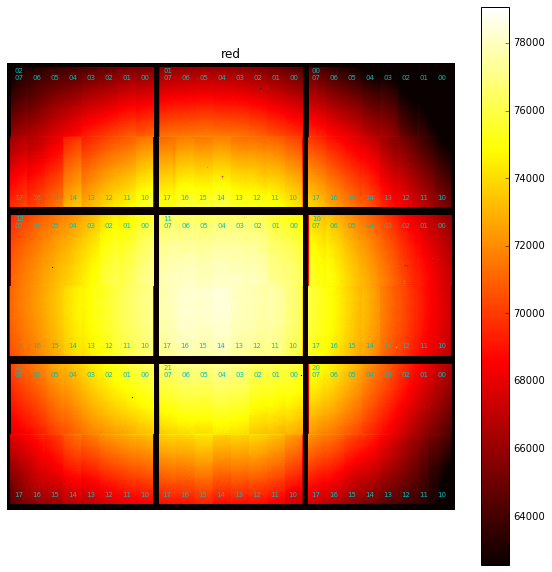

In [15]:
fig = dd_corr.plot(nsig=2, title = config['led_name'])
fig.savefig('corr_raft_image_'+config['led_name'])

## ... and compare to uncorrected image (no bias correction, no gain correction)

processing 02_CCOB_red_0.012A_0.06s_X300_Y192_0000_20171215013334.fits
processing 10_CCOB_red_0.012A_0.06s_X300_Y192_0000_20171215013334.fits
processing 00_CCOB_red_0.012A_0.06s_X300_Y192_0000_20171215013334.fits
processing 01_CCOB_red_0.012A_0.06s_X300_Y192_0000_20171215013334.fits
processing 20_CCOB_red_0.012A_0.06s_X300_Y192_0000_20171215013334.fits
processing 21_CCOB_red_0.012A_0.06s_X300_Y192_0000_20171215013334.fits
processing 22_CCOB_red_0.012A_0.06s_X300_Y192_0000_20171215013334.fits
processing 12_CCOB_red_0.012A_0.06s_X300_Y192_0000_20171215013334.fits
processing 11_CCOB_red_0.012A_0.06s_X300_Y192_0000_20171215013334.fits


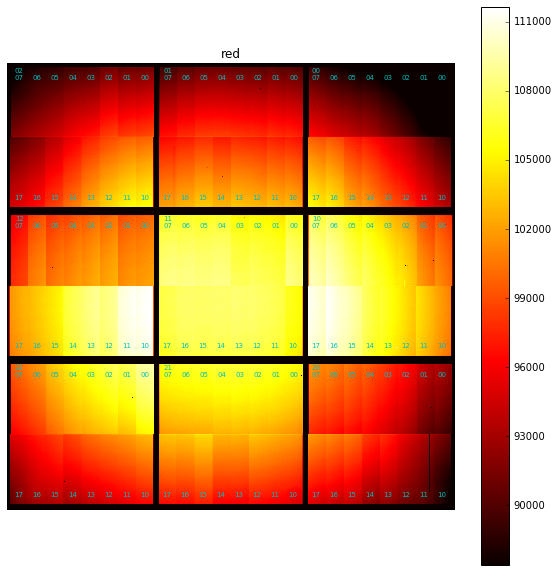

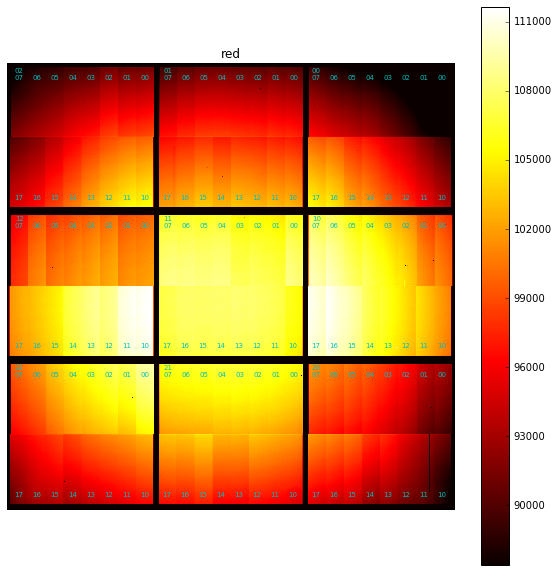

In [18]:
fits_files_dict={slot : fits_files_dict[slot] for slot in slot_names}
dd = raft.RaftMosaic(fits_files_dict)
dd.plot(nsig=2, title = config['led_name'])